<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/measuring_cnn_model_performance/measure_performance(individual_depths).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

In [ ]:
import pandas as pd

In [ ]:
import pickle

In [ ]:
import json
import os

# loading data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/imgs'

In [ ]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/imgs')

In [ ]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=123,
    batch_size=32,
    image_size=(224, 224),
    )

Found 3821 files belonging to 2 classes.
Using 3057 files for training.
Using 764 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['Blight', 'Gray_Leaf_Spot']

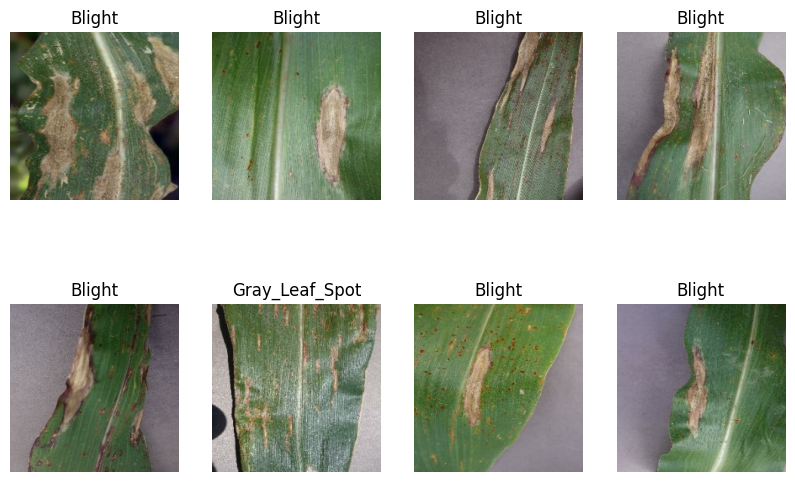

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## divide validation set to test & validation

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))


Number of validation batches: 24


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 4


# parameters and augmentations

In [ ]:
resize_and_rescale = keras.Sequential([
  keras.layers.Resizing(224, 224),
  keras.layers.Rescaling(1./127.5, offset=-1),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
no_of_classes = 2

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [ ]:
epochs = 150

# model

In [ ]:
def create_model(depth):
    model = tf.keras.models.Sequential()
    model.add(resize_and_rescale)
    model.add(data_augmentation)

    model.add(layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    for _ in range(depth - 1):
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(no_of_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

## Early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    mode='min',
                                                    patience=5,
                                                    restore_best_weights=True
                                                    )

# Training, Save and evaluation functions

In [ ]:
def train_and_save_history(depth, train_data, val_data, test_data, history_dir):
    model = create_model(depth)
    history = model.fit(
                          train_data,
                          batch_size=BATCH_SIZE,
                          validation_data=val_data,
                          verbose=1,
                          epochs=epochs,
                          callbacks=[early_stopping]
                          )
    evaluation = model.evaluate(test_data)

    # Combine history and evaluation metrics
    history_dict = history.history
    history_dict['test_loss'] = evaluation[0]
    history_dict['test_accuracy'] = evaluation[1]

    history_path = os.path.join(history_dir, f'history_depth_{depth}.json')
    with open(history_path, 'w') as f:
        json.dump(history_dict, f)

In [ ]:
def load_history(depth, history_dir):
    history_path = os.path.join(history_dir, f'history_depth_{depth}.json')
    with open(history_path, 'r') as f:
        history = json.load(f)
    return history

# Measure performance vs Layers

In [ ]:
history_path ='/content/drive/MyDrive/Colab Notebooks/FYP_code/measuring_cnn_model_performance/history'

## depth 1

In [ ]:
train_and_save_history(depth=1, train_data=train_ds, val_data=validation_dataset, test_data=test_dataset,history_dir=history_path)

Epoch 1/150
96/96 [==============================] - 18s 153ms/step - loss: 1.9474 - accuracy: 0.6016 - val_loss: 0.6198 - val_accuracy: 0.6682
Epoch 2/150
96/96 [==============================] - 16s 160ms/step - loss: 0.5645 - accuracy: 0.7105 - val_loss: 0.5272 - val_accuracy: 0.7091
Epoch 3/150
96/96 [==============================] - 16s 157ms/step - loss: 0.4583 - accuracy: 0.7910 - val_loss: 0.5509 - val_accuracy: 0.7500
Epoch 4/150
96/96 [==============================] - 16s 160ms/step - loss: 0.4215 - accuracy: 0.8188 - val_loss: 0.3959 - val_accuracy: 0.8396
Epoch 5/150
96/96 [==============================] - 16s 159ms/step - loss: 0.3933 - accuracy: 0.8456 - val_loss: 0.3612 - val_accuracy: 0.8506
Epoch 6/150
96/96 [==============================] - 16s 161ms/step - loss: 0.3751 - accuracy: 0.8472 - val_loss: 0.3632 - val_accuracy: 0.8553
Epoch 7/150
96/96 [==============================] - 19s 185ms/step - loss: 0.3659 - accuracy: 0.8557 - val_loss: 0.3636 - val_accuracy:

## depth 2

In [ ]:
train_and_save_history(depth=2, train_data=train_ds, val_data=validation_dataset, test_data=test_dataset,history_dir=history_path)

Epoch 1/150
96/96 [==============================] - 22s 190ms/step - loss: 0.6771 - accuracy: 0.6284 - val_loss: 0.4606 - val_accuracy: 0.7956
Epoch 2/150
96/96 [==============================] - 18s 177ms/step - loss: 0.4595 - accuracy: 0.7975 - val_loss: 0.4137 - val_accuracy: 0.8553
Epoch 3/150
96/96 [==============================] - 65s 676ms/step - loss: 0.3734 - accuracy: 0.8436 - val_loss: 0.3370 - val_accuracy: 0.8679
Epoch 4/150
96/96 [==============================] - 16s 157ms/step - loss: 0.3096 - accuracy: 0.8750 - val_loss: 0.2939 - val_accuracy: 0.8868
Epoch 5/150
96/96 [==============================] - 15s 153ms/step - loss: 0.2784 - accuracy: 0.8914 - val_loss: 0.2548 - val_accuracy: 0.9119
Epoch 6/150
96/96 [==============================] - 15s 153ms/step - loss: 0.2744 - accuracy: 0.8891 - val_loss: 0.2399 - val_accuracy: 0.9151
Epoch 7/150
96/96 [==============================] - 16s 157ms/step - loss: 0.2289 - accuracy: 0.9153 - val_loss: 0.2097 - val_accuracy:

## depth 3

In [ ]:
train_and_save_history(depth=3, train_data=train_ds, val_data=validation_dataset, test_data=test_dataset,history_dir=history_path)

Epoch 1/150
96/96 [==============================] - 18s 154ms/step - loss: 0.6129 - accuracy: 0.6412 - val_loss: 0.5314 - val_accuracy: 0.7044
Epoch 2/150
96/96 [==============================] - 15s 151ms/step - loss: 0.3979 - accuracy: 0.8207 - val_loss: 0.3469 - val_accuracy: 0.8538
Epoch 3/150
96/96 [==============================] - 15s 153ms/step - loss: 0.3216 - accuracy: 0.8629 - val_loss: 0.2505 - val_accuracy: 0.9198
Epoch 4/150
96/96 [==============================] - 18s 175ms/step - loss: 0.2641 - accuracy: 0.9028 - val_loss: 0.2448 - val_accuracy: 0.9182
Epoch 5/150
96/96 [==============================] - 15s 150ms/step - loss: 0.2300 - accuracy: 0.9133 - val_loss: 0.2904 - val_accuracy: 0.8899
Epoch 6/150
96/96 [==============================] - 15s 152ms/step - loss: 0.2556 - accuracy: 0.9019 - val_loss: 0.2398 - val_accuracy: 0.9104
Epoch 7/150
96/96 [==============================] - 15s 153ms/step - loss: 0.2109 - accuracy: 0.9244 - val_loss: 0.2100 - val_accuracy:

## depth 4

In [ ]:
train_and_save_history(depth=4, train_data=train_ds, val_data=validation_dataset, test_data=test_dataset,history_dir=history_path)

Epoch 1/150
96/96 [==============================] - 18s 160ms/step - loss: 0.5756 - accuracy: 0.6928 - val_loss: 0.4975 - val_accuracy: 0.7909
Epoch 2/150
96/96 [==============================] - 18s 183ms/step - loss: 0.3945 - accuracy: 0.8306 - val_loss: 0.4956 - val_accuracy: 0.7783
Epoch 3/150
96/96 [==============================] - 16s 158ms/step - loss: 0.3061 - accuracy: 0.8747 - val_loss: 0.2508 - val_accuracy: 0.9088
Epoch 4/150
96/96 [==============================] - 17s 162ms/step - loss: 0.2539 - accuracy: 0.9019 - val_loss: 0.2469 - val_accuracy: 0.9025
Epoch 5/150
96/96 [==============================] - 16s 153ms/step - loss: 0.2097 - accuracy: 0.9163 - val_loss: 0.1726 - val_accuracy: 0.9450
Epoch 6/150
96/96 [==============================] - 16s 154ms/step - loss: 0.2329 - accuracy: 0.9097 - val_loss: 0.2121 - val_accuracy: 0.9261
Epoch 7/150
96/96 [==============================] - 15s 153ms/step - loss: 0.2120 - accuracy: 0.9166 - val_loss: 0.1606 - val_accuracy:

## depth 5

In [ ]:
train_and_save_history(depth=5, train_data=train_ds, val_data=validation_dataset, test_data=test_dataset,history_dir=history_path)

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


96/96 [==============================] - 773s 8s/step - loss: 0.5724 - accuracy: 0.6919 - val_loss: 0.5090 - val_accuracy: 0.7673
Epoch 2/150
96/96 [==============================] - 16s 161ms/step - loss: 0.4193 - accuracy: 0.8142 - val_loss: 0.3506 - val_accuracy: 0.8381
Epoch 3/150
96/96 [==============================] - 16s 162ms/step - loss: 0.3476 - accuracy: 0.8659 - val_loss: 0.2975 - val_accuracy: 0.8711
Epoch 4/150
96/96 [==============================] - 19s 188ms/step - loss: 0.2891 - accuracy: 0.8934 - val_loss: 0.2918 - val_accuracy: 0.8884
Epoch 5/150
96/96 [==============================] - 17s 164ms/step - loss: 0.2769 - accuracy: 0.8950 - val_loss: 0.2573 - val_accuracy: 0.8931
Epoch 6/150
96/96 [==============================] - 16s 162ms/step - loss: 0.2533 - accuracy: 0.8992 - val_loss: 0.2902 - val_accuracy: 0.8852
Epoch 7/150
96/96 [==============================] - 16s 159ms/step - loss: 0.2464 - accuracy: 0.9084 - val_loss: 0.2024 - val_accuracy: 0.9340
Epoch 

## depth 6

In [ ]:
train_and_save_history(depth=6, train_data=train_ds, val_data=validation_dataset, test_data=test_dataset,history_dir=history_path)

Epoch 1/150
96/96 [==============================] - 19s 158ms/step - loss: 0.6795 - accuracy: 0.5764 - val_loss: 0.6135 - val_accuracy: 0.6368
Epoch 2/150
96/96 [==============================] - 16s 159ms/step - loss: 0.4800 - accuracy: 0.7785 - val_loss: 0.4109 - val_accuracy: 0.8318
Epoch 3/150
96/96 [==============================] - 16s 158ms/step - loss: 0.3846 - accuracy: 0.8436 - val_loss: 0.3643 - val_accuracy: 0.8585
Epoch 4/150
96/96 [==============================] - 16s 157ms/step - loss: 0.3340 - accuracy: 0.8728 - val_loss: 0.3177 - val_accuracy: 0.8758
Epoch 5/150
96/96 [==============================] - 16s 158ms/step - loss: 0.3102 - accuracy: 0.8855 - val_loss: 0.3410 - val_accuracy: 0.8506
Epoch 6/150
96/96 [==============================] - 16s 158ms/step - loss: 0.2979 - accuracy: 0.8849 - val_loss: 0.2646 - val_accuracy: 0.9009
Epoch 7/150
96/96 [==============================] - 16s 155ms/step - loss: 0.2781 - accuracy: 0.8940 - val_loss: 0.2519 - val_accuracy:

# Display Results

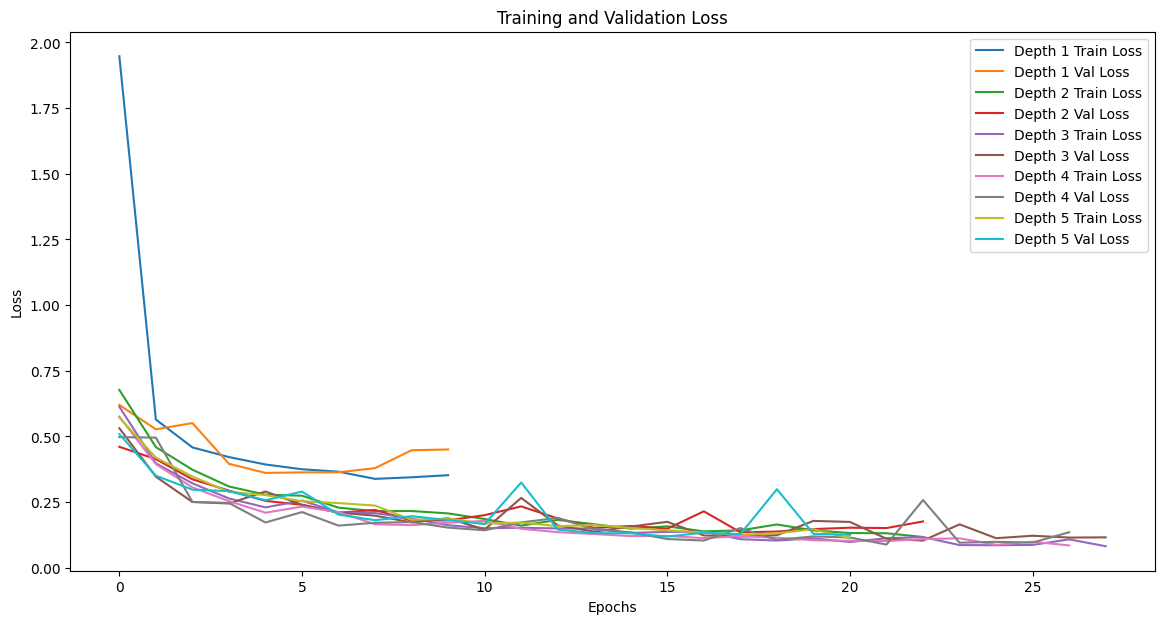

In [ ]:
# Plot training and validation loss for each depth
plt.figure(figsize=(14, 7))
for depth in range(1, 6):  # Example depths
    history = load_history(depth,history_path)
    plt.plot(history['loss'], label=f'Depth {depth} Train Loss')
    plt.plot(history['val_loss'], label=f'Depth {depth} Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Print test evaluation results for each depth
for depth in range(1, 7):
    history = load_history(depth,history_path)
    print(f"Depth {depth} Test Loss: {history['test_loss']}, Test Accuracy: {history['test_accuracy']}")

Depth 1 Test Loss: 0.2936631739139557, Test Accuracy: 0.8515625
Depth 2 Test Loss: 0.11532191187143326, Test Accuracy: 0.9453125
Depth 3 Test Loss: 0.10845264792442322, Test Accuracy: 0.984375
Depth 4 Test Loss: 0.08112160116434097, Test Accuracy: 0.96875
Depth 5 Test Loss: 0.09493986517190933, Test Accuracy: 0.9609375
Depth 6 Test Loss: 0.09944767504930496, Test Accuracy: 0.96875
